# Demonstrating the Virtual Epileptic Patient use-case

## 1. Initialize

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


//anaconda/envs/tvb-run/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import sys
import numpy as np
from vep.base.hypothesis import Hypothesis, X0_DEF
from vep.base.simulators import SimulationSettings
from vep.base.utils import filter_data
from vep.base.plot_tools import plot_connectivity, plot_hypothesis, plot_timeseries
from vep.episense.readers_episense import EpisenseReader
from vep.episense.simulator_episense import SimulatorEpisense
from vep.tvb_api.readers_tvb import TVBReader
from vep.tvb_api.simulator_tvb import SimulatorTVB

## 2. Read Data

First, set the input data path to a pipeline output folder, a TVB demo-data folder or an Episense Head:

In [3]:
reader = EpisenseReader()
data_folder = "/WORK/Episense/root-episense/trunk/demo-data/Head_TREC"

Then actually read data structures, and inspect them:

In [4]:
head = reader.read_head(data_folder)
print "Loaded Head ", head

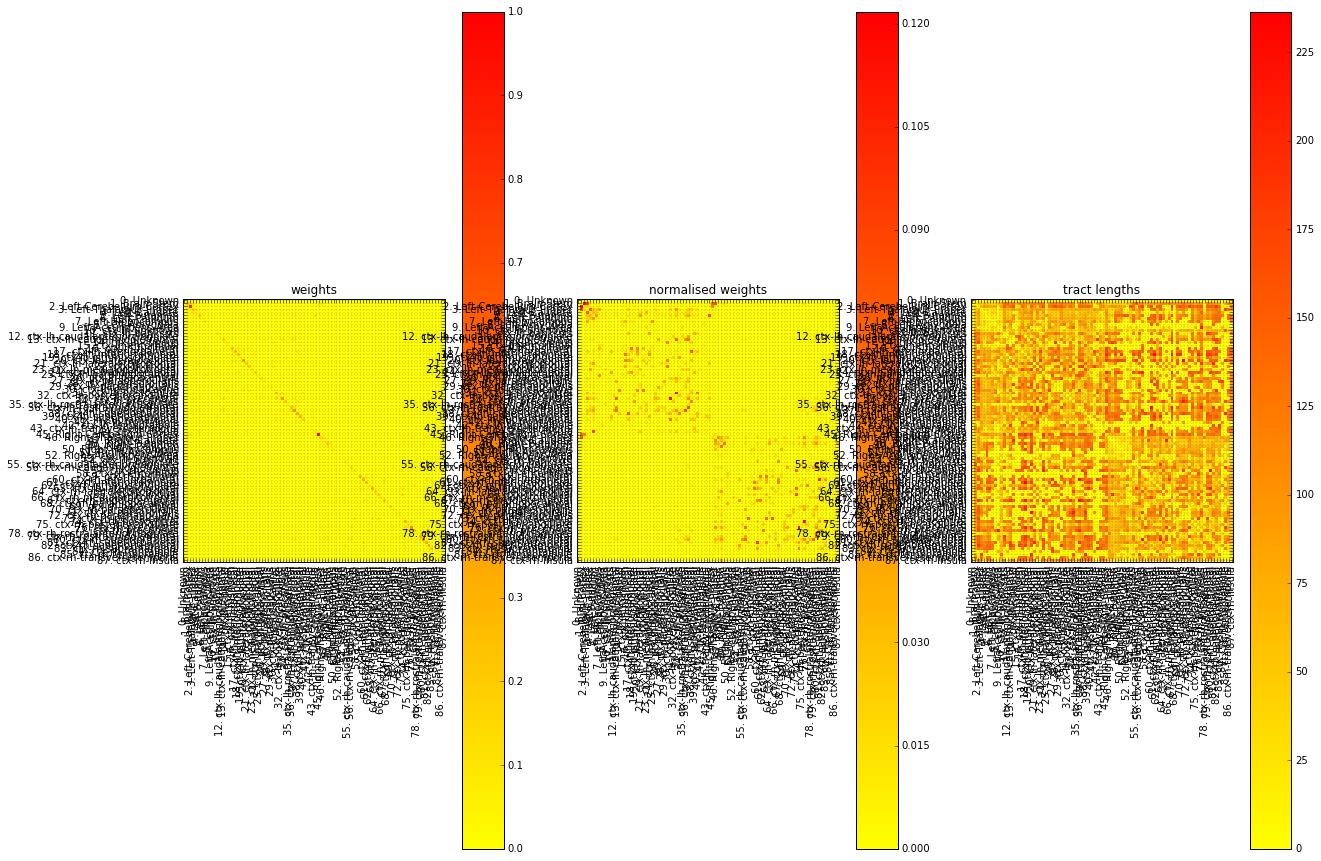

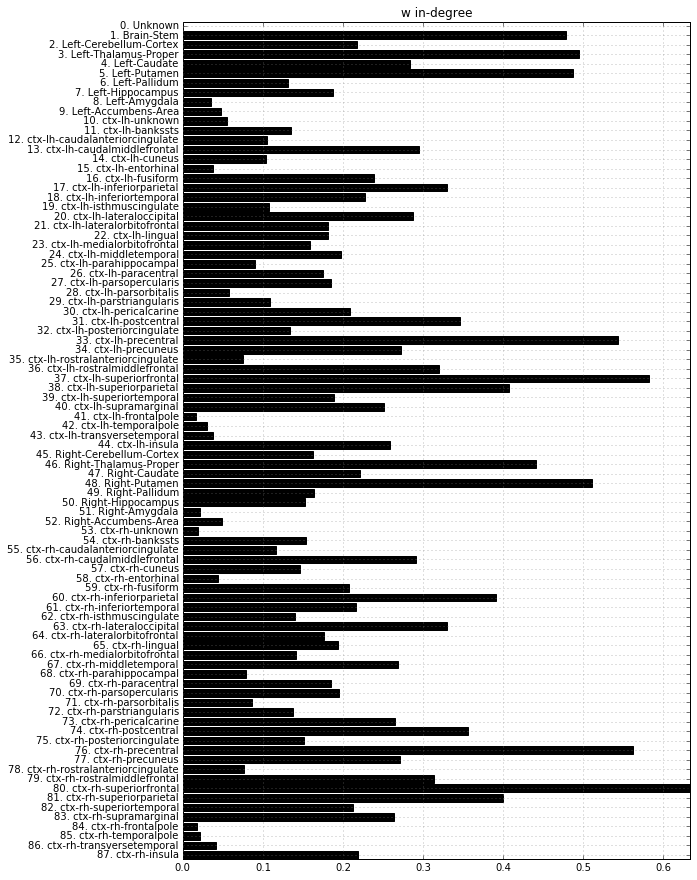

In [5]:
plot_connectivity(head.connectivity)

## 3. Define Disease Hypothesis

### A: EP Hypothesis

In [6]:
seizure_indices = np.array([7, 8, 15, 50], dtype=np.int32)

hyp_ep = Hypothesis(head.number_of_regions, head.connectivity.weights, "EP Hypothesis")
iE = np.array([1, 3, 7, 8, 15, 16, 25, 46, 50])
E = np.array([-0.25, -0.25, 0.0, 0.0, 0.0, -0.25, -0.25, -0.25, 0.0], dtype=np.float32)
hyp_ep.configure_e_hypothesis(iE, E, seizure_indices)
print hyp_ep

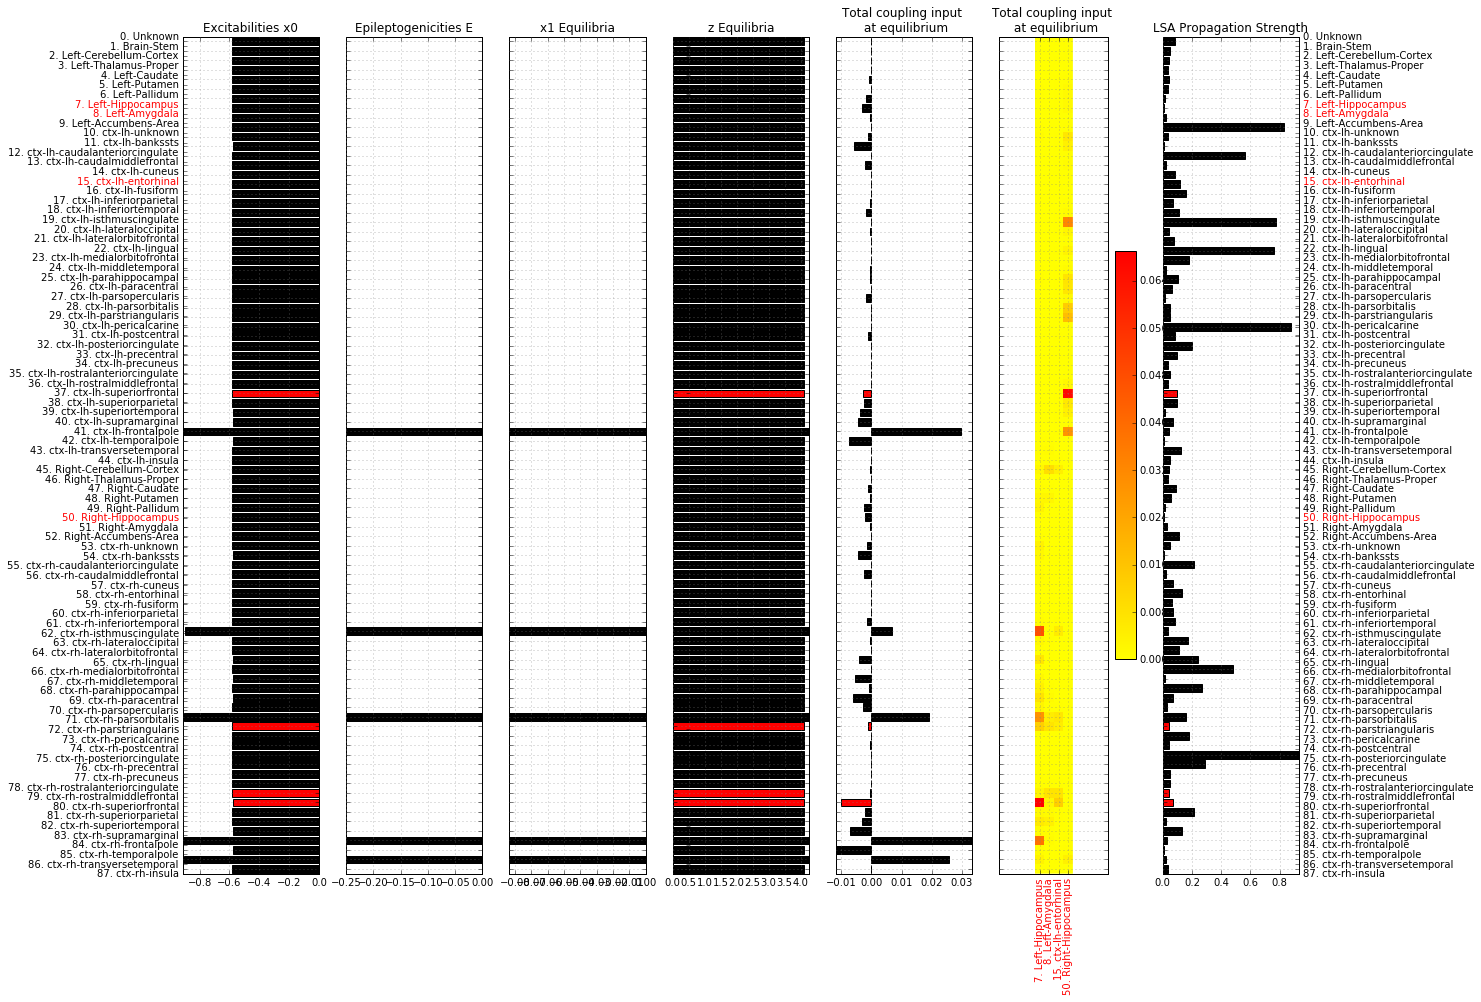

In [7]:
plot_hypothesis(hyp_ep, head.connectivity.region_labels)

### B. Excitability Hypothesis

In [8]:
hyp_exc = Hypothesis(head.number_of_regions, head.connectivity.weights, "Excitability Hypothesis")
ii = np.array(range(head.number_of_regions), dtype=np.int32)
ix0 = np.delete(ii, iE)
hyp_exc.configure_x0_hypothesis(ix0, X0_DEF, seizure_indices)
print hyp_exc

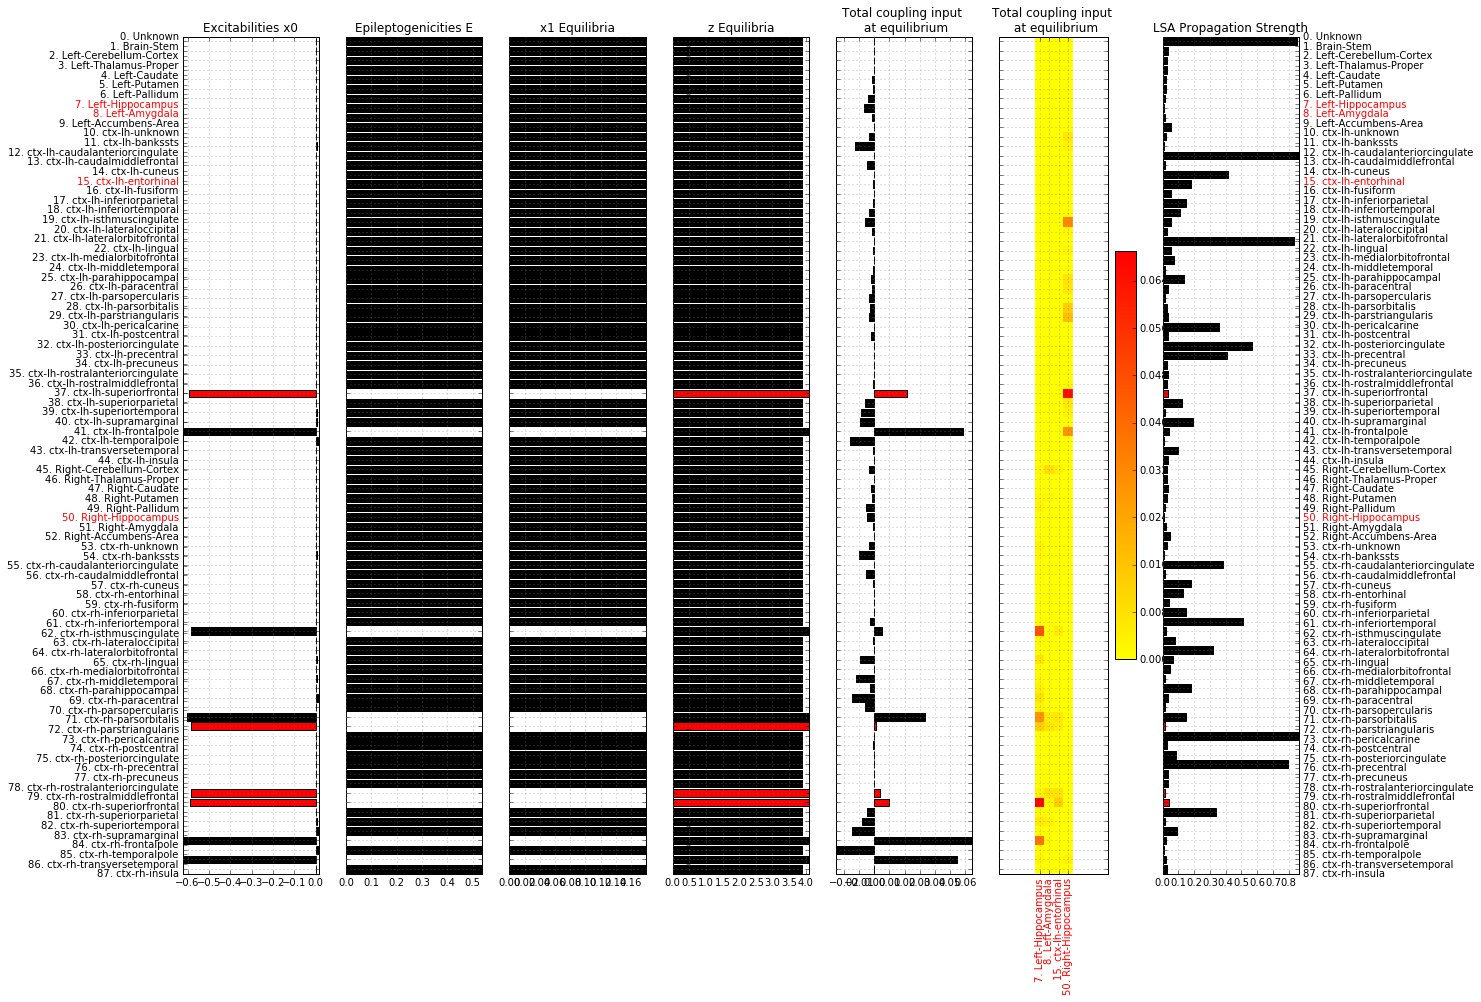

In [9]:
plot_hypothesis(hyp_exc, head.connectivity.region_labels)

## 4. Simulate

We will configure and run simulations for both Hypothesis defined above (EP and Exc).

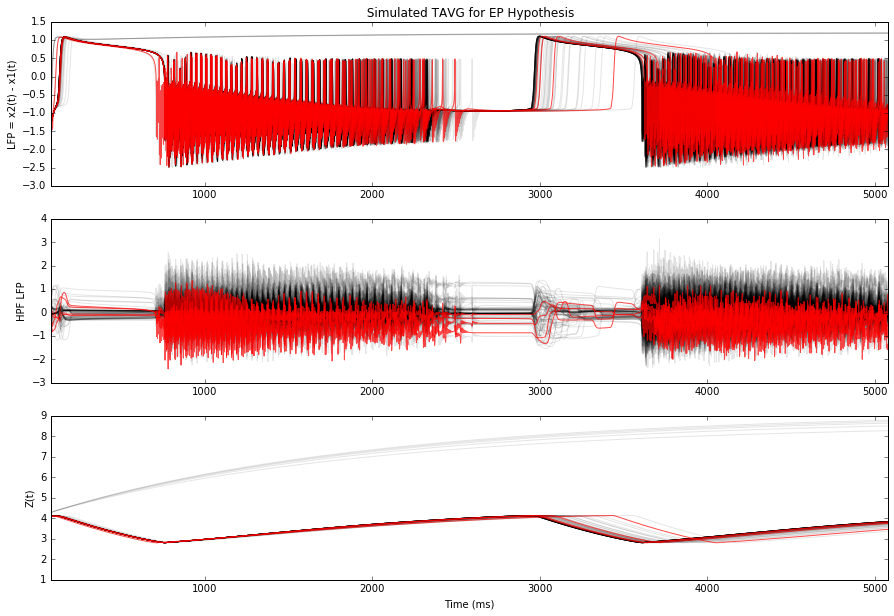

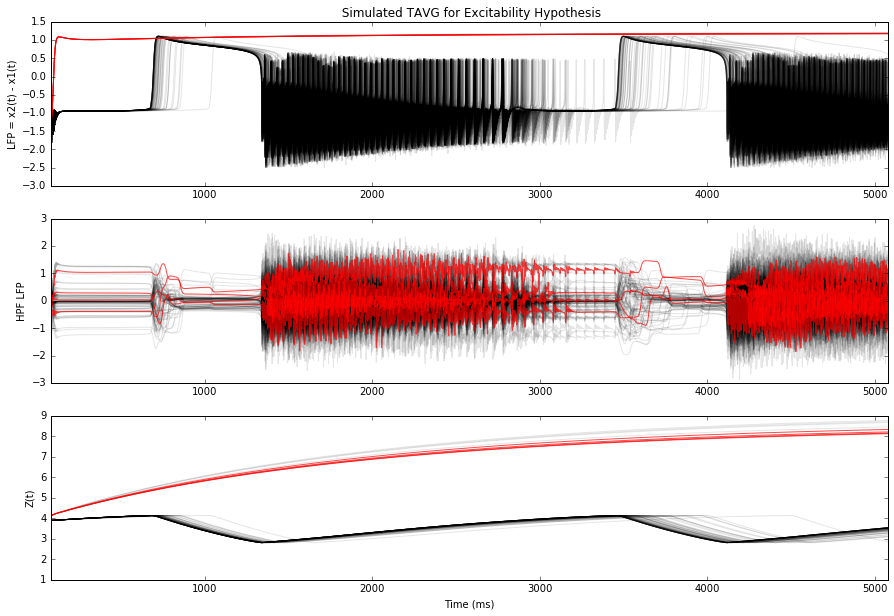

In [10]:
simulator = SimulatorTVB()

for hyp in (hyp_ep, hyp_exc):
        settings = SimulationSettings(noise_intensity=0)
        ttavg, tavg_data = simulator.launch_simulation(hyp, head, settings)
        print "Simulated signal return shape: ", tavg_data.shape
        print "Time: ", ttavg[0], ttavg[-1]
        print "Values: ", tavg_data.min(), tavg_data.max()
        lfp = tavg_data[:, 0, :, 0]
        z = tavg_data[:, 1, :, 0]
        hpf = filter_data(lfp, 10, 300, 1000.0/settings.monitor_sampling_period)
        plot_timeseries(ttavg, {'LFP = x2(t) - x1(t)': lfp, 'Z(t)': z, 'HPF LFP': hpf},
                        seizure_indices, title=" Simulated TAVG for " + hyp.name)